## Model Based Collaborative Filtering
*Implemented using Singular Value Decomposition (SVD) and Memory Based Collaborative Filtering by computing cosine similarity*

In [3]:
# Imports
# Science imports
import pandas as pd
import numpy as np

# Viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# Config matplotlib
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True # in matplotlib, edge borders are turned off by default. 
sns.set_style("darkgrid") # set a grey grid as a background

# ML imports
import sklearn
from sklearn import metrics
# Linear Regression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Logistic Regression
#
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# turn off warnings
import warnings
warnings.filterwarnings('ignore')



In [4]:
# Create columns
column_names = ['user_id','item_id','rating','timestamp']

In [8]:
pwd

'/Users/person/Coding/Machine_Learning_Python/Recommender_Systems'

In [9]:
# loading data
df = pd.read_csv("./u.data",sep='\t',names=column_names)

### Exporatory Data Analysis

Determine what the data teaches us about the model


In [9]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [10]:
# Get the movie titles
movie_titles = pd.read_csv("Movie_Id_Titles")

In [18]:
movie_titles.head(2)

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)


In [20]:
# Merge the movie titles dataframe to also incorporate the titles
df = pd.merge(df,movie_titles, on='item_id')

In [28]:
#df.drop('title_x',axis=1,inplace=True)
#df.drop('title_y',axis=1,inplace=True)

In [29]:
df.head()


,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


**exploring the data**

In [30]:
# Rank by Average Rating and Number Of Ratings
df.groupby('title')['rating'].mean()

title
'Til There Was You (1997)                                   2.333333
1-900 (1994)                                                2.600000
101 Dalmatians (1996)                                       2.908257
12 Angry Men (1957)                                         4.344000
187 (1997)                                                  3.024390
2 Days in the Valley (1996)                                 3.225806
20,000 Leagues Under the Sea (1954)                         3.500000
2001: A Space Odyssey (1968)                                3.969112
3 Ninjas: High Noon At Mega Mountain (1998)                 1.000000
39 Steps, The (1935)                                        4.050847
8 1/2 (1963)                                                3.815789
8 Heads in a Duffel Bag (1997)                              3.250000
8 Seconds (1994)                                            3.750000
A Chef in Love (1996)                                       4.125000
Above the Rim (1994)        

In [32]:
# See the most popular movies.
# Because we're seeing groupby it's possible that these aren't tallied by Popularity (number of 5 star ratings)
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [36]:
# which titles have the most votes
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [37]:
# now create a dataframe
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())

In [42]:
#index is title and rating is the mean of the ratings
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [43]:
# Now create a number of ratings column
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())

In [44]:
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


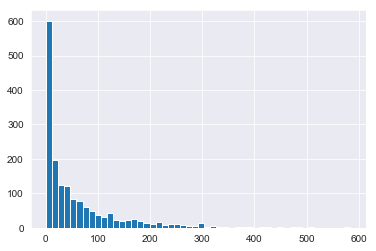

In [48]:
# Now explore this with Histograms
ratings['num of ratings'].hist(bins=50)

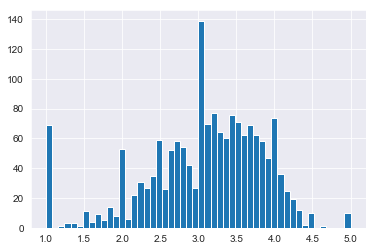

In [49]:
ratings['rating'].hist(bins=50)

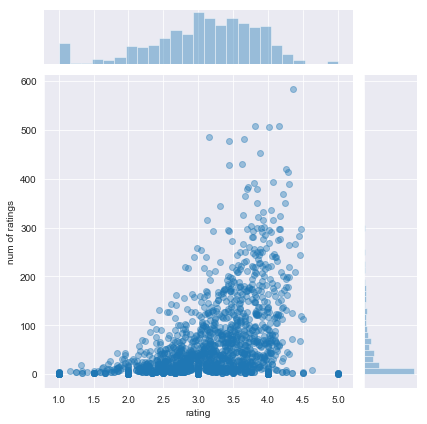

In [52]:
# is there a relationship between the average rating and the number of ratings?
# It appears that if you get more ratings it's more likely that you get a higher rating
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.4)

### Creating the Recommender System

First create a matrix that has the user ids on one axis and the movies on the other axis

We only care about user_id, Title and rating, so we'll use a pivottable to get the data into matrix form

In [54]:
moviemat = df.pivot_table(index='user_id',columns='title',values='rating')

In [55]:
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


In [57]:
# Get the User ratings for Star Wars and Liar Liar
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']

In [59]:
# We now have a series with the user_id and the rating they gave Star Wars (or none)
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

### Using pandas .corrwith() to determine correlation
**corrwith** to get the correlation between two pandas series.

**corrwith** will *Compute pairwise correlation between rows or columns of DataFrame with rows or columns of Series or DataFrame.*

In [62]:
moviemat.corrwith(starwars_user_ratings).head()

title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

In [63]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

In [65]:
# Notice now that every movie in the database has been assigned a rank of correlation with the rating to Star Wars,etc
similar_to_starwars.head()

title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

In [71]:
# now clear the null values and recreate with dataframes rather than series
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)

In [72]:
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


In [73]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)

In [74]:
corr_liarliar.head()

,Correlation
title,
'Til There Was You (1997),0.118913
101 Dalmatians (1996),0.469765
12 Angry Men (1957),0.066272
187 (1997),0.175145
2 Days in the Valley (1996),0.040739


Now that we have a correlation matrix we should be able to get a list of which movies are most similar. 

However this doesn't always work in a straightforward way.

Notice that 1.0 indicates a perfect correlation. But is "Man Of The Year" or "Commandments" really similar to Star Wars?

 This is probably because the movies were seen and rated only by one other person who also rated Star Wars highly. 

In [78]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Hollow Reed (1996),1.0
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Star Wars (1977),1.0
Man of the Year (1995),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


We can fix this by only showing movies that have a certain number of reviews as a threshhold.

You can use the earlier histogram to find what threshhold number makes sense, but we'll filter out movies with <100 reviews


In [79]:
# the reason we use .join() instead of .merge() is because "title" is the index of the dataframe
corr_starwars = corr_starwars.join(ratings['num of ratings'])

In [80]:
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [82]:
# Now filter out any movies that don't have at least 100 ratings
corr_starwars[corr_starwars['num of ratings']> 100].head()


,Correlation,num of ratings
title,,
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
2001: A Space Odyssey (1968),0.230884,259
Absolute Power (1997),0.085440,127
"Abyss, The (1989)",0.203709,151


In [83]:
# This starts making a lot more sense
corr_starwars[corr_starwars['num of ratings']> 100].sort_values('Correlation',ascending=False).head(10)

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


#### Now build for "Liar Liar"


In [84]:
# join the ratings
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])

In [85]:
# Now view the correlation for movies with greater than 100 reviews. Play around with the figures.
corr_liarliar[corr_liarliar['num of ratings']> 100].sort_values('Correlation',ascending=False).head(10)

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
Pretty Woman (1990),0.469790,164
101 Dalmatians (1996),0.469765,109
Michael (1996),0.442022,119
Waterworld (1995),0.438405,102


In [87]:
corr_liarliar[corr_liarliar['num of ratings']> 200].sort_values('Correlation',ascending=False).head(10)

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Indiana Jones and the Last Crusade (1989),0.414427,331
Top Gun (1986),0.405720,220
Back to the Future (1985),0.378028,350
Jurassic Park (1993),0.370770,261
"Saint, The (1997)",0.362803,316
Field of Dreams (1989),0.360339,212
"Shawshank Redemption, The (1994)",0.354533,283
Aladdin (1992),0.354506,219
